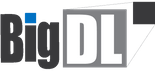
---

##### Copyright 2016 The BigDL Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

## **Environment Preparation**

**Install Java 8**

Run the cell on the **Google Colab** to install jdk 1.8.

**Note:** if you run this notebook on your computer, root permission is required when running the cell to install Java 8. (You may ignore this cell if Java 8 has already been set up in your computer).

In [ ]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

**Install BigDL**

 

[Conda](https://docs.conda.io/projects/conda/en/latest/user-guide/install/) is needed to prepare the Python environment for running this example. 

**Note**: The following code cell is specific for setting up conda environment on Colab; for general conda installation, please refer to the [install guide](https://docs.conda.io/projects/conda/en/latest/user-guide/install/) for more details.

In [ ]:
import sys

# Set current python version
python_version = "3.7.10"

In [ ]:
# Install Miniconda
!wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
!chmod +x Miniconda3-4.5.4-Linux-x86_64.sh
!./Miniconda3-4.5.4-Linux-x86_64.sh -b -f -p /usr/local

# Update Conda
!conda install --channel defaults conda python=$python_version --yes
!conda update --channel defaults --all --yes

# Append to the sys.path
_ = (sys.path
        .append(f"/usr/local/lib/python3.7/site-packages"))

os.environ['PYTHONHOME']="/usr/local"

You can install the latest pre-release version using `pip install --pre --upgrade bigdl-orca[automl]`.

In [ ]:
# Install latest pre-release version of Analytics Zoo 
# Installing Analytics Zoo from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre --upgrade bigdl-orca[automl]

In [ ]:
# Install python dependencies
!pip install torch==1.8.1 torchvision==0.9.1

## **Automated hyper-parameter search for PyTorch using Orca APIs**

In this guide we will describe how to enable automated hyper-parameter search for PyTorch using Orca `AutoEstimator` in 5 simple steps.

In [ ]:
# import necesary libraries and modules
from __future__ import print_function
import os
import argparse

from bigdl.orca import init_orca_context, stop_orca_context
from bigdl.orca import OrcaContext

### **Step 1: Init Orca Context**

In [ ]:
# recommended to set it to True when running Analytics Zoo in Jupyter notebook. 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

cluster_mode = "local"

if cluster_mode == "local":
    init_orca_context(cores=4, memory="2g", init_ray_on_spark=True) # run in local mode
elif cluster_mode == "k8s":
    init_orca_context(cluster_mode="k8s", num_nodes=2, cores=4, init_ray_on_spark=True) # run on K8s cluster
elif cluster_mode == "yarn":
    init_orca_context(
      cluster_mode="yarn-client", cores=4, num_nodes=2, memory="2g", init_ray_on_spark=True, 
      driver_memory="10g", driver_cores=1) # run on Hadoop YARN cluster

This is the only place where you need to specify local or distributed mode. View [Orca Context](https://bigdl.readthedocs.io/en/latest/doc/Orca/Overview/orca-context.html) for more details.

**Note**: You should export HADOOP_CONF_DIR=/path/to/hadoop/conf/dir when you run on Hadoop YARN cluster.

### **Step 2: Define the Model**
You may define your model, loss and optimizer in the same way as in any standard PyTorch program.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self, fc1_hidden_size=500):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, fc1_hidden_size)
        self.fc2 = nn.Linear(fc1_hidden_size, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

criterion = nn.NLLLoss()

After defining your model, you need to define a *Model Creator Function* that returns an instance of your model, and a *Optimizer Creator Function* that returns a PyTorch optimizer. Note that both the *Model Creator Function* and the *Optimizer Creator Function* should take `config` as input and get the hyper-parameter values from `config`.

In [ ]:
def model_creator(config):
    model = LeNet(fc1_hidden_size=config["fc1_hidden_size"])
    return model

def optim_creator(model, config):
    return torch.optim.Adam(model.parameters(), lr=config["lr"])

### **Step 3: Define Dataset**

You can define the train and validation datasets using *Data Creator Function* that has one parameter of `config` and returns a PyTorch `DataLoader`.

In [ ]:
import torch
from torchvision import datasets, transforms

torch.manual_seed(0)
dir = '/tmp/dataset'
test_batch_size = 640

def train_loader_creator(config):
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(dir, train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=config["batch_size"], shuffle=True)
    return train_loader

def test_loader_creator(config):
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(dir, train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=test_batch_size, shuffle=False)
    return test_loader

### **Step 4: Define search space**

You should define a dictionary as your hyper-parameter search space. The keys are hyper-parameter names which should be the same with those in your creators, and you can specify how you want to sample each hyper-parameter in the values of the search space. See [automl.hp](https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/AutoML/automl.html#orca-automl-hp) for more details.


In [ ]:
from bigdl.orca.automl import hp

search_space = {
    "fc1_hidden_size": hp.choice([500, 600]),
    "lr": hp.choice([0.001, 0.003]),
    "batch_size": hp.choice([160, 320, 640]),
}

### **Step 5: Automatically fit and search *with* Orca AutoEstimator**

First, create an AutoEstimator. You can refer to [AutoEstimator API doc](https://bigdl.readthedocs.io/en/latest/doc/PythonAPI/AutoML/automl.html#orca-automl-auto-estimator) for more details.

In [ ]:
from bigdl.orca.automl.auto_estimator import AutoEstimator

auto_est = AutoEstimator.from_torch(model_creator=model_creator,
                                    optimizer=optim_creator,
                                    loss=criterion,
                                    logs_dir="/tmp/orca_automl_logs",
                                    resources_per_trial={"cpu": 2},
                                    name="lenet_mnist")

Next, use the auto estimator to fit and search for the best hyper-parameter set.

In [ ]:
auto_est.fit(data=train_loader_creator,
             validation_data=test_loader_creator,
             search_space=search_space,
             n_sampling=2,
             epochs=1,
             metric="accuracy")

Finally, you can get the best learned model and the best hyper-parameters.

In [ ]:
best_model = auto_est.get_best_model()

In [ ]:
best_config = auto_est.get_best_config()
print(best_config)

You can use the best learned model and the best hyper-parameters as you want. Here, we demonstrate how to evaluate on the test dataset.

In [ ]:
test_loader = test_loader_creator(best_config)
best_model.eval()
correct = 0
with torch.no_grad():
  for data, target in test_loader:
    output = best_model(data)
    pred = output.data.max(1, keepdim=True)[1]
    correct += pred.eq(target.data.view_as(pred)).sum().numpy()
accuracy = 100. * correct / len(test_loader.dataset)
print(f"accuracy is {accuracy}%")

You can find the accuracy of the best model has reached 98%.

In [ ]:
# stop orca context when program finishes
stop_orca_context()